<div style="text-align: center; font-size: 40px; font-weight: bold;">IMAGE CAPTION GENERATOR</div>
<div style="height: 50px;"></div>

In [3]:
import numpy as np
import pandas as pd
import os
import pickle
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from keras.utils import load_img, img_to_array, pad_sequences, to_categorical,plot_model
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from nltk.translate.bleu_score import sentence_bleu

# Data Generator

In [7]:
# path to working directory
working_dir = os.getcwd()
# path to data
data_path=os.path.join(os.getcwd(), 'Data')
# path to images
image_dir = os.path.join(data_path, 'Images')
# path to features.pkl
features_path = os.path.join(data_path, 'features.pkl')
# load features
with open(features_path, 'rb') as file:
    features = pickle.load(file)    
# path to mapping.pkl
mapping_path = os.path.join(data_path, 'mapping.pkl')
# load mapping
with open(mapping_path, 'rb') as file:
    mapping = pickle.load(file)

In [8]:
# create a list of all captions
all_captions = [caption for captions in mapping.values() for caption in captions]
# get the maximum length of the available labels
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [9]:
# tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
vocab_size

8485

In [10]:
# train test split
image_ids=list(mapping.keys())
split=int(len(image_ids)* .90)
train=image_ids[:split]
test=image_ids[split:]

In [5]:
# create data generator
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize lists to store image data, text images and predictions
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # create sequences
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # split up
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad sequences
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Output-sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # add sequence to list
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

## Modell erstellen

In [11]:
# Image layers
image_input=Input(shape=(4096,))
drop1=Dropout(.1)(image_input)
encoder_ouputs=Dense(256,activation="relu")(drop1)

# Text layers
caption_input=Input(shape=(max_length,))
embed=Embedding(vocab_size,256,mask_zero=True)(caption_input)
drop2=Dropout(0.1)(embed)
decoder_ouputs=LSTM(256)(drop2)

# combine
add_layer=add([encoder_ouputs,decoder_ouputs])
dense_layer=Dense(256,activation="relu")(add_layer)
outputs=Dense(vocab_size,activation="softmax")(dense_layer)

model=Model(inputs=[image_input,caption_input],outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2172160   ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                              

In [27]:
# train the model
batch_size = 300
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
steps = len(train) // batch_size
model.fit(generator, epochs=40, steps_per_epoch=steps, verbose=1)

Epoch 1/40


24/24 [==============================] - 314s 13s/step - loss: 6.3190 - accuracy: 0.0819
Epoch 2/40
24/24 [==============================] - 271s 11s/step - loss: 5.4829 - accuracy: 0.1235
Epoch 3/40
24/24 [==============================] - 279s 12s/step - loss: 5.0862 - accuracy: 0.1406
Epoch 4/40
24/24 [==============================] - 284s 12s/step - loss: 4.7960 - accuracy: 0.1541
Epoch 5/40
24/24 [==============================] - 282s 12s/step - loss: 4.4995 - accuracy: 0.1790
Epoch 6/40
24/24 [==============================] - 347s 15s/step - loss: 4.1663 - accuracy: 0.2144
Epoch 7/40
24/24 [==============================] - 364s 15s/step - loss: 3.8875 - accuracy: 0.2393
Epoch 8/40
24/24 [==============================] - 364s 15s/step - loss: 3.6875 - accuracy: 0.2589
Epoch 9/40
24/24 [==============================] - 380s 16s/step - loss: 3.5226 - accuracy: 0.2764
Epoch 10/40
24/24 [==============================] - 383s 16s/step - loss: 3.3860 - accuracy: 0.29

In [28]:
model.save("my_model.h5")

In [29]:
model = keras.models.load_model('my_model.h5')

## Caption generieren

In [30]:
# define a function that converts integer to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate captions
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # indexing
        yhat = np.argmax(yhat)
        # Convert indexing to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        # Input for generating the next word
        in_text += " " + word
        # stop when we reach the end tag
        if word == 'endseq':
            break

    return in_text

In [33]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    # adjust the size of the image to the VGG16 input size
    image = image.resize((224, 224))  
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # preprocess the image
    new_image = preprocess_image(image_path)

    # generate features for the new image using the pre-trained VGG16 model
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Predict caption for the new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # remove the startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # capitalize the first letter
    predicted_caption = predicted_caption.capitalize()

    # add a dot
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # display the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()


# Predict and evaluate

## Predict

Now we can make some predictions of captions for several images

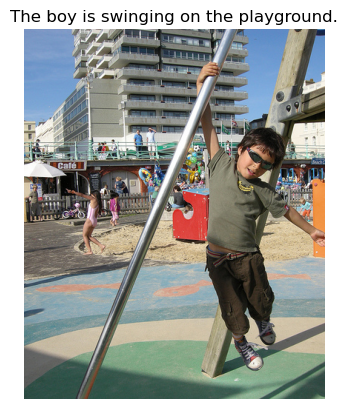

In [34]:
# first example
new_image_path = os.path.join(os.getcwd(), 'Data/Images/3759492488_592cd78ed1.jpg')
generate_caption_for_new_image(new_image_path)

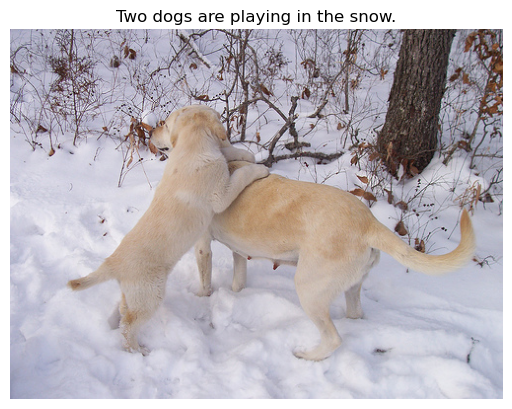

In [98]:
# another example
new_image_path = os.path.join(os.getcwd(), 'Data/Images/133905560_9d012b47f3.jpg')
generate_caption_for_new_image(new_image_path)

## Evaluate

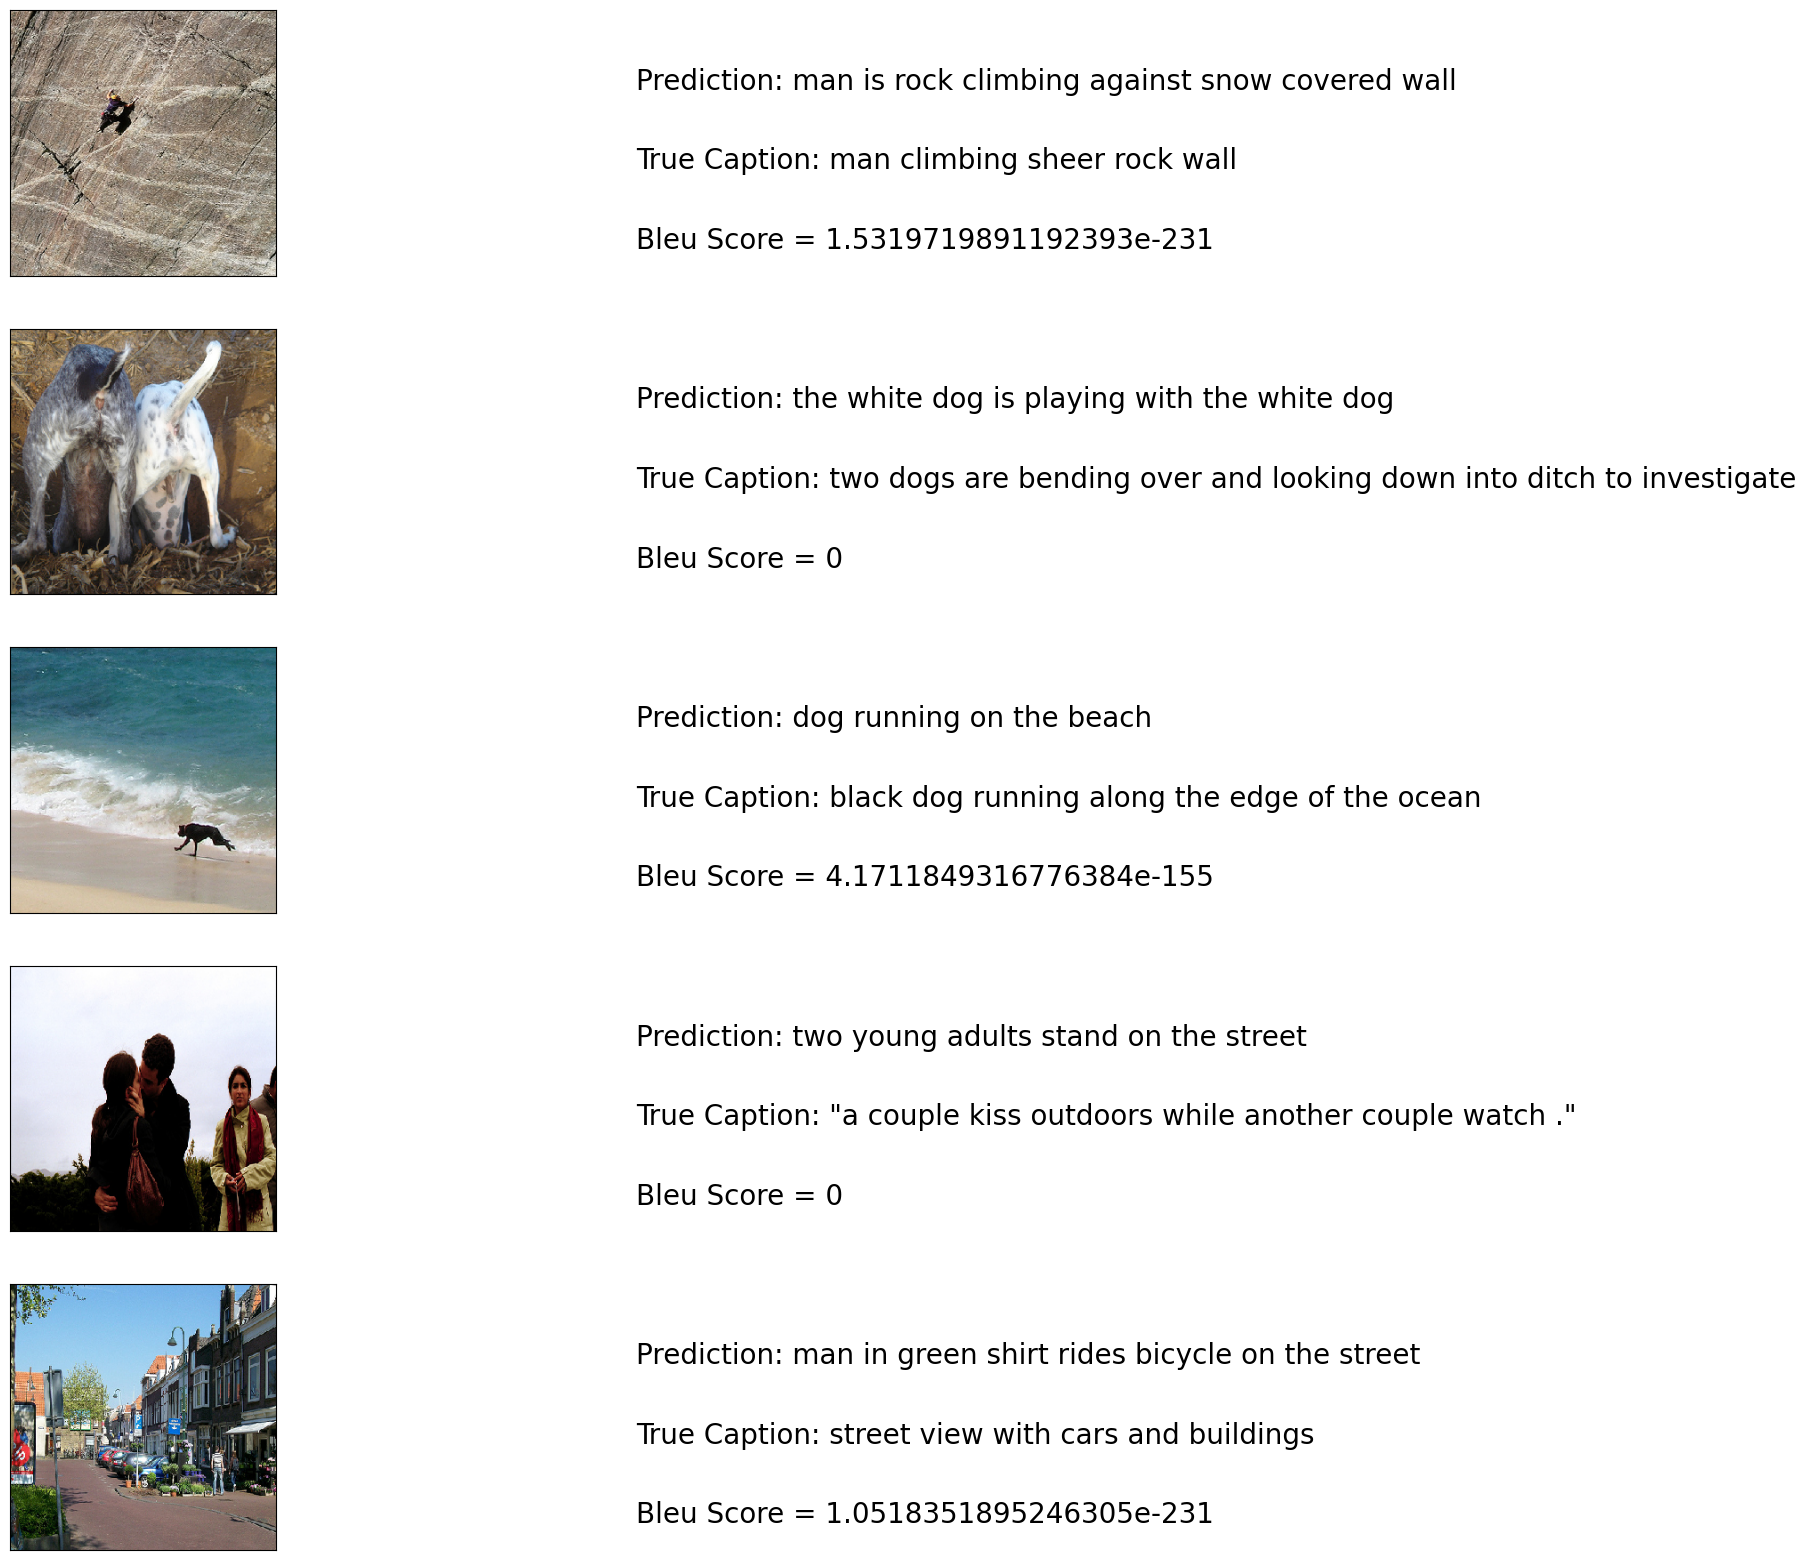

In [100]:
# 5 test examples with True_Caption and Bleu score

npic = 5
target_size = (299, 299)
path = os.path.join(data_path, 'Images/')
fig = plt.figure(figsize=(20,20))

count = 1
for img in os.listdir(path)[split:][101: npic+101]:
    
    filename = path + img
    caption=list(mapping[img.split(".")[0]])[0]
    true_caption = ' '.join(caption.split()[1: -1])
    
    new_image = preprocess_image(filename)

    # generate features for new image
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # predict caption for new image
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  

    # remove startseq and endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()
    
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0,0.7,'Prediction: '+predicted_caption, fontsize=20)
    ax.text(0,0.4, 'True Caption: '+ true_caption, fontsize=20)
    ax.text(0, 0.1, 'Bleu Score = {}'.format(sentence_bleu([true_caption.split()], predicted_caption.split())), fontsize = 20)
    count += 1
plt.show()

Due to the limitation of dataset, when we test the result with new images, it might happen that we can get some ridiculous and funny descriptions

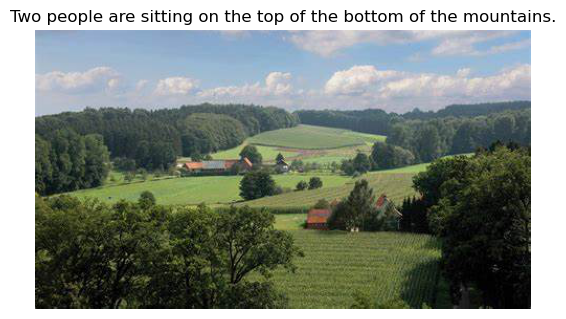

In [41]:
new_image_path = os.path.join(os.getcwd(), 'Pictures/test1.jpg')
generate_caption_for_new_image(new_image_path)

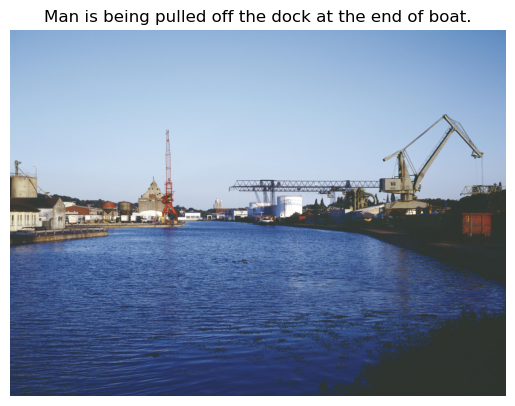

In [42]:
new_image_path = os.path.join(os.getcwd(), 'Pictures/test2.jpg')
generate_caption_for_new_image(new_image_path)